## **GRADTDA 5621 - Week 15 Synchronous Class**

### **Overview**  
There are several ways to obtain or generate data, structured (e.g., a table or document) and unstructured (e.g., web scraping or raw text). In this case we will obtain annotated text data from a GitHub repository. The idea is to demonstrate how to clone a repository in an environment (Colab) and then work through the repository's natural tree-based structure. The output of this exercise will be an application which identifies drug strings (aka., chemical entities) in synthetic clinician notes and then searches RxNorm (National Library of Medicine) via sequential API calls to obtain the drug's properties.  

### **Demonstrated concepts**  
* Github (e.g., repository clone)  
* Natural Language Processing (e.g., Named Entity Recognition)
* HTTP API (e.g., RxNav)  

### **References**  
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8449609/  
* https://github.com/UTHealth-CCB/synthetic_hpi_ner  
* https://allenai.github.io/scispacy/  
* https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

####**Data**  
Data is stored as annotated '.bio' files within a folder. A special type of reading and parsing is required for this type of file. The contents resemble something like, "recently\tO\ndiagnosed\tO\nMDS\tB-problem\n...". Fortunately, the file format and contents follow an excpected structure that we're able to interact with via [Biopython](https://biopython.org/).

Obtain the Data

In [1]:
# Clone the Github repository where synthetic, annotated clinician notes are stored
! git clone https://github.com/UTHealth-CCB/synthetic_hpi_ner.git

Cloning into 'synthetic_hpi_ner'...
remote: Enumerating objects: 854, done.
remote: Total 854 (delta 0), reused 0 (delta 0), pack-reused 854
Receiving objects: 100% (854/854), 22.66 MiB | 23.97 MiB/s, done.
Resolving deltas: 100% (120/120), done.


Access and Process the Data

In [2]:
# Install non-standard libraries
! pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00


In [3]:
import os
from Bio import File
from Bio import SeqIO

def parse_annotated_bio_file(file_location):

  # Instantiate two lists to write the parsed sentences to
  main_phrases = []
  temp_tokens = []

  # Open the first file to understand the contents
  with File.as_handle(file_location, 'r') as f:

      # Parse the annotated text (e.g., word\t<annotation>\n)
      for record in SeqIO.parse(f, 'tab'):

        # Check if the end of a phrase has been reached
        # identified by a comma or period
        if record.id.strip() == '.':

          # Convert the tokens to a common English phrase
          main_phrases.append(' '.join(temp_tokens) + '.')

          # Reset the list of phrase tokens
          temp_tokens = []

        else:
          # Append the phrasetoken
          temp_tokens.append(record.id)

  # Close the open file
  f.close()

  # Return the final list of phrases
  return main_phrases

In [4]:
# Create a list of datafile names from the cloned repo directory
file_path = 'synthetic_hpi_ner/data/annotation/synth'
file_names = os.listdir(file_path)

# Preview the unordered list of file names
file_names[0:10]

['69.bio',
 '272.bio',
 '307.bio',
 '170.bio',
 '247.bio',
 '336.bio',
 '329.bio',
 '379.bio',
 '493.bio',
 '323.bio']

In [10]:
# Parse a single file as an example (selected file in the list)
parsed_phrases = parse_annotated_bio_file(os.path.join(file_path, file_names[32]))

# Preview the fifth phrase, in the selected file (see file_names[32], above)
print(f'The first sentence in the {os.path.join(file_path, file_names[32])} file is:\n"{parsed_phrases[2]}"')

The first sentence in the synthetic_hpi_ner/data/annotation/synth/294.bio file is:
"She has been taking her usual regimen of Advil and Tamiflu."


####**Biomedical Named Entity Recognition**  
Now we'll use basic natural language processing capabilities to identify disease and chemical entities via a pre-trained biomedical model available via [scispaCy](https://allenai.github.io/scispacy/). In this case, we're only interested in specific entities and only if the entities are attributed to the patient (aka., ignore negated terms [e.g., 'not arthritis']). The results of the named entity recognition (aka., NER) pipeline can be displayed, written out as an annotation (e.g., for a classification model), and/or stored for further processing.

Load the pre-trained model and instantiate the NER pipeline

In [ ]:
# Install non-standard libraries
! pip install scispacy
! pip install negspacy

In [ ]:
# Install the task-specific pre-trained language model
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_ner_bc5cdr_md-0.5.3.tar.gz

In [8]:
import scispacy
import spacy
from negspacy.negation import Negex

# Instantiate the biomedical language model, specific to the task
# NOTE: loading a language model takes time to complete
nlp = spacy.load("en_ner_bc5cdr_md")

# Add the Negation pipeline
nlp.add_pipe('negex', config={'ent_types':['DISEASE', 'CHEMICAL']})

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Parse and tag the corpus (e.g., example sentence)

In [11]:
# Test the entity recognition pipeline (named 'nlp') with a single sentence
temp_tagged = nlp(parsed_phrases[2])

In [12]:
# Extract any tagged entities, if the entity is not negated
tagged_ent_list = [(x, x.label_) for x in temp_tagged.ents if x._.negex == False]
print(f'Tagged, non-negated entities stored in memory:\n{tagged_ent_list}')

Tagged, non-negated entities stored in memory:
[(Advil, 'CHEMICAL'), (Tamiflu, 'CHEMICAL')]


In [13]:
# Control the colors of the tagged entities
color_options = {'ents': ['DISEASE', 'CHEMICAL'], 'colors': {'DISEASE': '#6899E9', 'CHEMICAL': '#E9B868'}}

# Display the tagged corpus
print('Visualization of tagged entities:')
spacy.displacy.render(temp_tagged, style='ent', options=color_options, jupyter=True)

Visualization of tagged entities:


####**API to Decribe Chemical Entities**  
Integrating additional data and capabilties via the web is often easy to do via the use of [REST APIs](https://realpython.com/api-integration-in-python/). In our case, we will be utlizing the library of APIs made available by the National Library of Medicine. Specifically, we'll use the [RxNorm APIs](https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html) to  

1.   convert the entity string (e.g., Advil) into a RxCUI value, and
2.   obtain documented properties about the drug (e.g., currently prescribable).

If this were a production application, there would be additional considerations for monitoring how many calls are being made, if the service is available, handling errors, and logging results. These additional considerations are outside of the scope of this exercise.

In [14]:
import requests
import json

# User function to execute pre-planned RxNorm API calls
def rxnorm_interaction(search_key, search_property, api_choice='string to cui', response_format='json'):

  """
  Core Reference
    https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

  Parameters
    search_key: unique search item (id, term, etc.) to query
    search_property: optional API filter properties, specific to each API
    api_choice: current options include 'string to cui' or 'cui properties'
    response_format: current options include 'json' or 'xml'

  API Choice Details
    'string to cui': https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxNorm.findRxcuiByString.html
    'cui properties': https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxNorm.getAllProperties.html
  """

  # Root URL
  root_url = 'https://rxnav.nlm.nih.gov/REST/rxcui'

  # Pre-planned API options
  if api_choice == 'string to cui':
    dynamic_url = f'{root_url}.{response_format}?name={search_key}&{search_property}'
  elif api_choice == 'cui properties':
    dynamic_url = f'{root_url}/{search_key}/allProperties.{response_format}?prop={search_property}'
  else:
    raise Exception('Invalid API Choice provided.')

  # Call the RxNorm API
  response = requests.request('GET', dynamic_url)

  # Conditionally return response
  if response.status_code == 200:
    return response
  else:
    raise Exception(f'Error calling API. Status code is {response.status_code}.')

In [15]:
# Step 1:Retrieve the entity's CUI code
cui_resp = rxnorm_interaction(search_key=tagged_ent_list[1][0], search_property='search=1')

# Parse the JSON response to obtain the desired CUI code
cui_string = cui_resp.json()['idGroup']['rxnormId'][0]

In [16]:
# Step 2: Retrieve the drug properties via CUI code
prop_resp = rxnorm_interaction(search_key=cui_string, search_property='ALL', api_choice='cui properties')

# Parse the JSON response to obtain all properties of the drug and display in a clean, indented form
print(f"{tagged_ent_list[1][0]} is identified by the CUI, {cui_string}. The drug's properties include:\n\n{json.dumps(prop_resp.json(), indent=3)}")

Tamiflu is identified by the CUI, 261657. The drug's properties include:

{
   "propConceptGroup": {
      "propConcept": [
         {
            "propCategory": "ATTRIBUTES",
            "propName": "BN_CARDINALITY",
            "propValue": "single"
         },
         {
            "propCategory": "ATTRIBUTES",
            "propName": "GENERAL_CARDINALITY",
            "propValue": "SINGLE"
         },
         {
            "propCategory": "ATTRIBUTES",
            "propName": "PRESCRIBABLE",
            "propValue": "Y"
         },
         {
            "propCategory": "ATTRIBUTES",
            "propName": "RXNAV_HUMAN_DRUG",
            "propValue": "US"
         },
         {
            "propCategory": "ATTRIBUTES",
            "propName": "TTY",
            "propValue": "BN"
         },
         {
            "propCategory": "CODES",
            "propName": "MMSL_CODE",
            "propValue": "BN31447"
         },
         {
            "propCategory": "CODES",
          

####**Bringing it All Together**  
So far, we've illustrated how various functions can be applied on a single file, record, named entity, etc. Many production applications require a streamlined method for executing all steps in an analysis. Doing so may limit the potential for error due to manual intervention or simply meets replication requirements.  

Here we will combine all of the previously defined functions into one main function and will process the multiple files at once, across several cores (aka., multi-threading or parallel processing). The output of this main function should be a dataset which can be used for additional modeling and/or analysis.  

In production, we would be required to test the accuracy of the entity recognition model and adjust accordingly. We would test for accuracy, overfitting, bias, etc. We may also consider testing several NER capabilities to compare the speed, compute cost, and accuracy of each option.

In production, we would be concerned about proper use of the RxNorm APIs. For example, APIs normally have a limit on the number of calls which can be made from the same IP Addres during a period of time. We would also typically need to consider how the data will be used and any other stipulations mentionied in the [Terms of Service](https://lhncbc.nlm.nih.gov/RxNav/TermsofService.html).

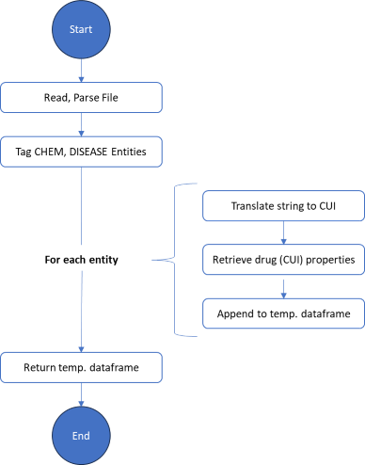

In [17]:
import re
import pandas as pd

def bio_file_aggregator(in_file):

  # Instantiate an empty list to write to
  temp_df_list = []

  # Establish the file name without the path
  in_file_name = re.findall(r'/(\d+).bio', in_file)[0]

  try:
    # Parse a single file as an example (file_names[370])
    parsed_phrases = parse_annotated_bio_file(in_file)

    # Convert the parsed phrases into a single corpus (document)
    parsed_document = ' '.join(parsed_phrases)

    # Test the entity recognition pipeline (named 'nlp') with a single sentence
    document_tagged = nlp(parsed_document)

    # Extract any tagged entities and its label, if the entity is not negated
    document_entity_list = [(x, x.label_) for x in document_tagged.ents if x._.negex == False]

    for entity in document_entity_list:

      # The API function is only developed for 'CHEMICAL' entities (aka., drugs)
      # Additional APIs and scispaCy pipelines are available to process 'DISEASE' entities (out of scope for this exercise)
      if entity[1] == 'CHEMICAL':

        # Retrieve the entity's CUI code (E.G., 6)
        entity_cui_resp = rxnorm_interaction(search_key=entity[0], search_property='search=1')

        try:
          # Parse the JSON response to obtain the desired CUI code
          entity_cui_string = entity_cui_resp.json()['idGroup']['rxnormId'][0]

          # Retrieve the drug properties via CUI code
          entity_prop_resp = rxnorm_interaction(search_key=entity_cui_string, search_property='ALL', api_choice='cui properties')

          # Parse the response content
          entity_prop_json = entity_prop_resp.json()

          # Prepare the temp dataframe to be concatenated as a final step after looping
          temp_df = pd.DataFrame(entity_prop_json['propConceptGroup']['propConcept'])

          # Add the retrieved CUI value as a new column
          temp_df.insert(0, 'CUI', entity_cui_string)

          # Add the entity string as it was found in the corpus, as a new column
          temp_df.insert(0, 'chemicalEntity', str(entity[0]).strip().lower())

          # Add the file name where the entity was found, as a new column
          temp_df.insert(0, 'fileName', in_file_name)

          # Append the entity-specific dataframe to temp list
          temp_df_list.append(temp_df)

        # If any error occurs in the preceding property data development, simply skip
        # In a production application, we would properly handle errors or empty results
        except:
          continue

    # Concatenate the list of dataframes and return a single dataframe for analysis
    # In a production application we would properly handle and log errors at this level, too
    final_df = pd.concat(temp_df_list)

    # Clean up the index as a new dataframe
    final_df.reset_index(drop=True, inplace=True)

    # Return the full corpus dataframe
    return final_df

  except:
    raise Exception(f'Error occurred when processing {in_file_name}. Skipping.')

In [18]:
import concurrent
import multiprocessing
from tqdm import tqdm

# # Main application will need to be applied for each file in the repo
# for bio_file in file_names:

# Instantiate an empty list to write dataframes to
multi_list = []

def multi_execution(file_name, file_path=file_path, out_list=multi_list):

  try:
    # Run the individual file parser, tagger, appending the result
    out_list.append(bio_file_aggregator(os.path.join(file_path, file_name)))

  except:
    # If failure, continue processing
    pass

# Establish the number of CPU to spread the work across
# slightly overprescribing the CPUs via a multiplier
n_cpu = multiprocessing.cpu_count() * 10

# Loop through all of the files in the repo, processing, appending results
# Use a master progress bar to track the progress of processing all 500 files
with concurrent.futures.ThreadPoolExecutor(max_workers=n_cpu) as tpe:
  list(tqdm(tpe.map(multi_execution, file_names), total=len(file_names)))

# Concatenate the total list of dataframes into a single dataframe
chem_entities_df = pd.concat(multi_list)

# Reset the index of the new dataframe for tidiness
chem_entities_df.reset_index(drop=True, inplace=True)

# Print a sample of the new dataframe
chem_entities_df.head()

100%|██████████| 500/500 [04:29<00:00,  1.85it/s]


,fileName,chemicalEntity,CUI,propCategory,propName,propValue
0,342,oxygen,7806,ATTRIBUTES,GENERAL_CARDINALITY,SINGLE
1,342,oxygen,7806,ATTRIBUTES,PRESCRIBABLE,Y
2,342,oxygen,7806,ATTRIBUTES,RXNAV_HUMAN_DRUG,US
3,342,oxygen,7806,ATTRIBUTES,RXNAV_VET_DRUG,US
4,342,oxygen,7806,ATTRIBUTES,TTY,IN


####**Quick review of the results**  
Take a quick peek at some interesting counts, values, etc.

In [19]:
# Review the list of properties returned
chem_entities_df['propName'].unique()

array(['GENERAL_CARDINALITY', 'PRESCRIBABLE', 'RXNAV_HUMAN_DRUG',
       'RXNAV_VET_DRUG', 'TTY', 'ATC', 'DRUGBANK', 'MMSL_CODE', 'RxCUI',
       'SNOMEDCT', 'SPL_SET_ID', 'UNII_CODE', 'USP', 'VUID', 'RXNAV_STR',
       'RxNorm Name', 'Source', 'Tallman Synonym', 'BN_CARDINALITY',
       'RxNorm Synonym', 'ACTIVATED', 'SCHEDULE'], dtype=object)

In [20]:
# Prescribable/not distribution of tagged entities
chem_entities_df.loc[(chem_entities_df.propName == 'PRESCRIBABLE'), ].groupby(['propValue', 'CUI'])['fileName'].count().sort_values(ascending=False)

propValue  CUI    
Y          11124      41
           8640       38
           235473     35
           7806       31
           3628       28
                      ..
           4603        1
           4617        1
           4815        1
           202472      1
           1999003     1
Name: fileName, Length: 155, dtype: int64

In [21]:
# Which entity shows up most often across all 500 bio files?
chem_entities_df.loc[(chem_entities_df.CUI == '11124'), 'chemicalEntity'].drop_duplicates().to_list()

['vancomycin']